In [23]:
%matplotlib inline

#Source code with the blog post at http://monik.in/a-noobs-guide-to-implementing-rnn-lstm-using-tensorflow/
import numpy as np
import random
from random import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.special as sps


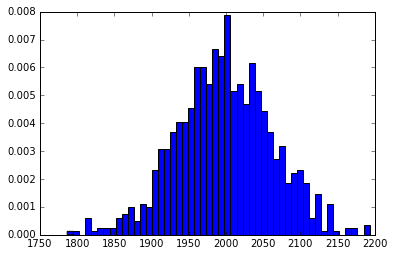

In [24]:
shape, scale = 1000., 2. # mean and dispersion
s = np.random.gamma(shape, scale, 1000)
count, bins, ignored = plt.hist(s, 50, normed=True)
y = bins**(shape-1)*(np.exp(-bins/scale) / (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')
plt.show()

In [25]:
np.random.gamma(100, 1)

101.05683772243572

In [77]:
def load_keystrokes(log_file):
    with open(log_file, 'r') as f:
        data = [[int(i) for i in line.split(',')] for line in f]
    data_count = len(data)
    data = [x for x in data if x[0] > 0]
    clean_data_count = len(data)

    print("Loaded {} events, {} removed".format(clean_data_count, data_count - clean_data_count))
    return data

david_data = load_keystrokes("annex/david.log")
robert_data = load_keystrokes("annex/robert.log")
marcel_data = load_keystrokes("annex/marcel2.log")

Loaded 4490 events, 6 removed
Loaded 17513 events, 0 removed
Loaded 987 events, 0 removed


In [64]:
# muddle positive time_delta data to generate negative samples
NUM_EXAMPLES = 100
SEQ_LENGTH = 200

assert len(david_data) >= SEQ_LENGTH

def random_sub_seq(xs):
    # TODO extend to support variable size sequences
    start = int(np.random.uniform(0, len(xs) - SEQ_LENGTH))
    end = start + SEQ_LENGTH
    return xs[start:end]

def fuzz_datapoint(x, bias):
    dt, char = x
    # using gamma distribution since P(x <= 0) = 0 if x~Gamma(shape, scale), that is, prob of getting low dt's near 0 is low
    scale = 1.5
    return [np.random.gamma(dt / scale / bias, scale), char]

train_input = []
train_output = []

for i in range(NUM_EXAMPLES * 10):
    if np.random.rand() < 0.5:
        # positive sample
        train_input.append(random_sub_seq(david_data))
        train_output.append([1, 0])
    else:
        # negative sample
        train_input.append(random_sub_seq(marcel_data))
        train_output.append([0, 1])

In [65]:
avg_seq_length = sum(len(x) for x in train_input) / len(train_input)
min_seq_length = min(len(x) for x in train_input)
max_seq_length = max(len(x) for x in train_input)
print("avg seq len: {}".format(avg_seq_length))
print("min seq len: {}".format(min_seq_length))
print("max seq len: {}".format(max_seq_length))

avg seq len: 200.0
min seq len: 200
max seq len: 200


In [66]:
test_input = train_input[NUM_EXAMPLES:]
test_output = train_output[NUM_EXAMPLES:]
train_input = train_input[:NUM_EXAMPLES]
train_output = train_output[:NUM_EXAMPLES]

print("test and training data loaded")

test and training data loaded


In [12]:
data = tf.placeholder(tf.float32, [None, SEQ_LENGTH,2]) #Number of examples, number of input, dimension of each input
target = tf.placeholder(tf.float32, [None, 2])
num_hidden = 24
cell = tf.nn.rnn_cell.LSTMCell(num_hidden,state_is_tuple=True)
val, _ = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)
weight = tf.Variable(tf.truncated_normal([num_hidden, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))
prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
cross_entropy = -tf.reduce_sum(target * tf.log(prediction))
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)
mistakes = tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:89: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
sess = tf.Session()

In [14]:
saver = tf.train.Saver()

In [15]:
saver.restore(sess, "model.ckpt")
print("Model restored.")

Model restored.


In [ ]:
init_op = tf.initialize_all_variables()
sess.run(init_op)

In [74]:
batch_size = 10
no_of_batches = int(len(train_input)) // batch_size
epoch = 10
print("Batch size: {} || batches: {} || epochs: {}".format(batch_size, no_of_batches, epoch))
for i in range(epoch):
    ptr = 0
    for j in range(no_of_batches):
        inp, out = train_input[ptr:ptr+batch_size], train_output[ptr:ptr+batch_size]
        ptr+=batch_size
        sess.run(minimize,{data: inp, target: out})
    
 
    if i % 10 == 0:
        incorrect = sess.run(error,{data: test_input, target: test_output})
        print('Epoch {:2d} error {:3.1f}%'.format(i, 100 * incorrect))
    else:
        pass #print("Epoch ",str(i))
    save_path = saver.save(sess, "model.ckpt")

incorrect = sess.run(error,{data: test_input, target: test_output})
#print(sess.run(prediction,{data: [[[1],[0],[0],[1],[1],[0],[1],[1],[1],[0],[1],[0],[0],[1],[1],[0],[1],[1],[1],[0]]]}))
print('Epoch {:2d} error {:3.1f}%'.format(i + 1, 100 * incorrect))

Batch size: 10 || batches: 10 || epochs: 10
Epoch  0 error 13.0%
Epoch 10 error 12.8%


In [75]:
good = [test_input[i] for i in range(len(test_output)) if test_output[i] == [1, 0]]
bad = [test_input[i] for i in range(len(test_output)) if test_output[i] == [0, 1]]
bad = [[[b[0], b[1]] for g, b in zip(good[i], bad[i])] for i in range(min(len(good), len(bad)))]

In [76]:
sess.run(prediction,{data: good}).mean(axis=0), sess.run(prediction,{data: bad}).mean(axis=0)

(array([ 0.84376222,  0.15623771], dtype=float32),
 array([ 0.1489425 ,  0.85105723], dtype=float32))

In [62]:
save_path = saver.save(sess, "model.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: model.ckpt


In [171]:
current_keystrokes = load_keystrokes('./annex/key_logging/keystroke.log')[-SEQ_LENGTH:]

inp, out = [current_keystrokes], [[1,0]]

print(sess.run(prediction,{data: inp}).mean(axis=0))
#sess.run(minimize,{data: inp, target: out})
#print(sess.run(prediction,{data: [current_keystrokes]}).mean(axis=0))

Loaded 4823 events, 3 removed
[ 0.05279499  0.94720507]


In [ ]:
log_file = "recent2.log"
with open(log_file, 'r') as f:
    raw_data = [[int(i) for i in line.split(',')] for line in f]

raw_data_count = len(raw_data)
raw_data = [x for x in raw_data if x[0] > 0]
clean_data_count = len(raw_data)
raw_data = raw_data[:-50]
print("Loaded {} events, {} removed".format(clean_data_count, raw_data_count - clean_data_count))

In [ ]:
sess.run(error,{data: [random_sub_seq(raw_data) for _ in range(100)]}).mean(axis=0)

In [ ]:
sess.close()

In [20]:
len([x for x in good if x[0] < 10])

TypeError: unorderable types: list() < int()